In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


# Cumulative spring migration for all stations

## Load data

In [9]:
root = "../data-1.0.0"

# Read each yearly data frame and combine them
dfs = []
years = range(1995, 2023)
for year in years:
    file = f"{root}/daily/{year}-daily.csv"
    df = pd.read_csv(file, parse_dates=['date'])
    df = df[df['period']=='night']
    dfs.append(df)

df = pd.concat(dfs)

# Read station metadata and merge with data
station_df = pd.read_csv(f"{root}/meta/nexrad-stations.csv")
df = df.merge(station_df, left_on='station', right_on='callsign')

# Save original data frame
orig_df = df.copy()

## Filter data and add cumulative reflectivity

In [13]:
df = orig_df

# Add useful columns and filter data
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.dayofyear

df = df.query('year >= 1999') # 1999 and later
df = df.query('day >= 60 & day <= 165') # spring only

# Compute cumulative reflectivity for each station-year
field = 'traffic'

df[field] = df[field].fillna(0)
df['cum_migration'] = df.groupby(['year', 'station'])[field].cumsum()
total_migration = df.groupby(['year', 'station'])[field].transform('sum')
df['cum_migration'] = df['cum_migration'] / total_migration

# Compute fraction missing for each station-year
df['fraction_missing'] = df['fraction_missing'].fillna(1.0)
df['overall_fraction_missing'] = df.groupby(['year', 'station'])['fraction_missing'].transform('mean')

# Drop if too many missing values
df = df.query('overall_fraction_missing < 0.2') 

# Reindex
df = df.sort_values(by=['station', 'date']).reset_index(drop=True)

## Plot by station

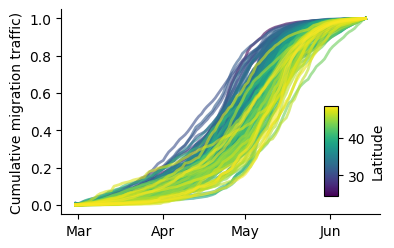

In [32]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# size and margins for all plots to line them up
figsize = (4, 2.5)
left, right, top, bottom = 0.16569444444444445, 0.9625, 0.95, 0.1290740740740741


# Keep only US stations
df = df[df['station'].str.startswith("K")]

# Create a date column with fixed year for formatting
df['t'] = df['date'].apply(lambda x: x.replace(year=2000))

# Use seaborn to create the plot
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(data=df, x = 't', y='cum_migration', hue='lat', 
                  palette='viridis', errorbar=None, linewidth=2, 
                  legend=False, alpha=0.6, ax = ax)

# Format axes
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
sns.despine(ax = ax, top = True, right = True)
plt.ylabel('Cumulative migration traffic)')
plt.xlabel(None)

# Add colorbar
norm = matplotlib.colors.Normalize(vmin=df['lat'].min(), vmax=df['lat'].max())
cmap = sns.color_palette("viridis", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
axins = inset_axes(ax, width="4%", height="40%", 
                   loc='lower right', bbox_to_anchor=(0, 0.175, 0.875, 0.9),
                   bbox_transform=fig.transFigure)
cbar = plt.colorbar(sm, cax=axins, orientation='vertical')
cbar.set_label('Latitude')
#fig.tight_layout()
plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom) 
plt.savefig("plots/phenology-stations.pdf", dpi=300) 


# Plot by year for KHGX

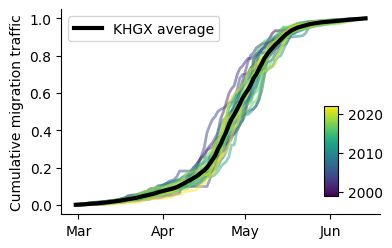

In [33]:


fig, ax = plt.subplots(figsize=figsize)
khgx = df.query('station == "KHGX"')

sns.lineplot(data=khgx, ax = ax,
             x = 't', y='cum_migration', hue='year', 
             palette='viridis', linewidth=2, alpha = 0.5, legend=False)

# khgx.pivot(
#     index=["t"],
#     columns="year",
#     values="cum_migration"
# ).plot(legend=False, color='gray', ax = ax, alpha=0.3)

sns.lineplot(data=khgx, ax = ax,
             x = 't', y='cum_migration', errorbar=None, linewidth=3, color='black', legend=True, label='KHGX average')

# Format axes
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
sns.despine(ax = ax, top = True, right = True)
plt.ylabel('Cumulative migration traffic')
plt.xlabel(None)

# Add colorbar
norm = matplotlib.colors.Normalize(vmin=khgx['year'].min(), vmax=khgx['year'].max())
cmap = sns.color_palette("viridis", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is needed for the colorbar to work properly
#axins = inset_axes(ax, width="5%", height="50%", loc='lower right', borderpad=3)
axins = inset_axes(ax, width="4%", height="40%", 
                   loc='lower right', bbox_to_anchor=(0, 0.175, 0.875, 0.9),
                   bbox_transform=fig.transFigure)
cbar = plt.colorbar(sm, cax=axins, orientation='vertical')
#cbar.set_label('')
plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom) 


# left, right, top, bottom = fig.subplotpars.left, fig.subplotpars.right, fig.subplotpars.top, fig.subplotpars.bottom
# print(left, right, top, bottom)


plt.savefig("plots/phenology-khgx.pdf", dpi=300)


# Plot reflectivity by year for two stations

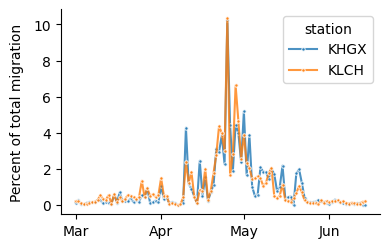

In [29]:
fig, ax = plt.subplots(figsize=figsize)

# Compute percent migration
field = 'traffic'
df['total_migration'] = df.groupby(['year', 'station'])[field].transform('sum')
df['percent_migration'] = 100 * df[field] / df['total_migration']

# Subset data
data = df.query('station == ["KHGX", "KLCH"] & year == 2007')

# Plot
sns.lineplot(data=data, ax=ax, x='t', y='percent_migration', hue='station', marker='.', markersize=5, alpha=0.8)
#sns.barplot(data=data, ax=ax, x='t', y='percent_migration', hue='station', alpha=0.8)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
sns.despine(ax = ax, top = True, right = True)
plt.ylabel('Percent of total migration', labelpad=7)
plt.xlabel(None)
#plt.tight_layout()
plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom) 
plt.savefig("plots/daily-migration.pdf", dpi=300)

